# Aufgabe 11 - Trading Environment Setup
22.01.2022, Thomas Iten

**Content**
0. Setup
1. Load S&P 500 Dataset
2. Define Trading Environment
3. Create Trading Environment and visualize some state values
4. Test some random actions and visualize the rewards

## 0. Setup

In [18]:
import random
import numpy as np
import gym
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from dataset import SP500DataSet
from env import TradingEnv

## 1. Load S&P 500 Dataset

In [19]:
ds = SP500DataSet()
df_train, df_test = ds.get_train_test()

Load SP500 from file: ./sp500.csv
Define data splits:
- Train rows : 2542 ( 85%)
- Val   rows : 0000 ( 0%)
- Test  rows : 0448 ( 15%)
- Total rows : 2990 (100%)

Define data shapes:
- Train shape: (2542, 490)
- Val   shape: (0, 490)
- Test  shape: (448, 490)
- Total shape: (2990, 490)


### Head of train data

In [20]:
df_train.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.007375,-0.014569,-0.002473,0.015445,0.0,0.021253,0.001145,0.008668,0.013641,0.008393,...,0.012689,0.013980,0.004539,0.0,0.003426,0.015278,0.011224,0.038231,0.0,0.016817
2010-01-05,-0.010922,0.107246,-0.005962,0.001727,0.0,-0.007160,-0.024321,-0.008112,0.006162,0.016313,...,-0.012689,0.003897,-0.011959,0.0,-0.003426,0.031165,-0.001745,0.034651,0.0,0.002644
2010-01-06,-0.003559,-0.042314,0.008682,-0.016034,0.0,-0.009501,-0.015358,0.005539,0.010574,-0.002124,...,-0.006807,0.008606,0.006566,0.0,-0.007174,-0.000323,-0.007717,0.083382,0.0,0.000704
2010-01-07,-0.001297,0.029044,-0.000247,-0.001850,0.0,-0.016166,0.000000,0.008250,-0.000935,-0.019595,...,-0.010095,-0.003147,0.013005,0.0,-0.000288,0.022681,-0.025318,0.106160,0.0,0.004212
2010-01-08,-0.000325,-0.019268,0.003945,0.006626,0.0,0.010807,-0.020446,0.005099,-0.003986,-0.005436,...,0.014505,-0.004020,0.000000,0.0,0.000288,-0.021228,-0.003256,-0.016320,0.0,0.003322


### Head of test data

In [21]:
df_test.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-10,0.015036,0.014343,-0.017071,0.004738,0.026306,0.017894,-0.071112,0.004882,0.004574,0.010624,...,0.013631,-0.010617,0.006111,0.017891,0.008101,0.011634,0.005204,-0.012625,0.025939,0.007438
2020-02-11,0.007787,0.035822,0.010884,-0.006052,0.013106,0.010310,0.009946,0.009805,-0.001931,-0.001948,...,0.043808,0.009461,0.009528,0.017577,0.011405,0.006740,-0.002982,0.013706,0.010329,0.001732
2020-02-12,0.003988,0.020893,0.016590,0.023470,0.018474,0.012714,-0.051826,-0.004271,-0.000707,0.013476,...,0.009699,0.012151,0.000172,0.021433,0.012322,-0.003711,0.016727,0.003694,-0.007317,0.006422
2020-02-13,0.000468,-0.012550,0.002602,-0.007147,-0.025268,-0.008848,-0.012902,-0.001240,0.001932,0.001468,...,-0.008371,-0.005565,0.001722,-0.023613,0.001525,0.000189,-0.076978,0.007131,0.013615,-0.001068
2020-02-14,0.004086,-0.030024,-0.008052,0.000246,-0.013728,-0.001694,0.014578,0.010990,-0.000141,0.012803,...,-0.002658,-0.004606,-0.004484,0.012444,0.002377,0.010466,0.023090,-0.003883,-0.005327,0.001601


## 2. Define Trading Environment


In [22]:
class TradingEnv(gym.Env):
    """The S&P 500 Trading Environment."""

    INITIAL_IDX = 0
    INITIAL_CASH = 10_000
    INITIAL_PORTFOLIO_VALUE = 0

    ACTIONS = ["sell", "hold", "buy"]

    def __init__(self, df_train, df_test, play=False):
        # df and starting index
        self.df = df_test if play else df_train
        self.current_idx = TradingEnv.INITIAL_IDX

        # cash and portfolio
        self.cash = TradingEnv.INITIAL_CASH
        self.portfolio_value = TradingEnv.INITIAL_PORTFOLIO_VALUE

        # target stocks and stock values
        self.stocks = ['AAPL', 'MSFT', 'AMZN', 'NFLX', 'XOM', 'JPM', 'T'] # target stocks
        self.stock_values = np.zeros(len(self.stocks))

        # number, states and rewards
        self.n = len(self.df)
        self.states = self.df.loc[:, ~self.df.columns.isin(self.stocks)].to_numpy()
        self.rewards = self.df[self.stocks].to_numpy()

        # last step data
        self.last_step = None


    def reset(self):
        self.current_idx = TradingEnv.INITIAL_IDX
        self.cash = TradingEnv.INITIAL_CASH
        self.portfolio_value = TradingEnv.INITIAL_PORTFOLIO_VALUE
        self.stock_values = np.zeros(len(self.stocks))
        state = self.states[self.current_idx]
        state = np.array(state).reshape(1, -1)
        self.last_step = None
        return state


    def step(self, action):
        """
        Run the give action, take a step forward and return the next state with the reward and done flag.

        The actions calculates the difference between the mean value of the next states and the current states.

        The reward is then calculated according the following table:

            Action      Difference   Rise    Reward
            sell        positive     True    -10
            sell        negative     False   +10
            buy         positive     True    +20
            buy         negative     False   -10
            hold        n/a          n/a       0

        :param action: ["sell", "hold", "buy"]
        :return: next_state, reward, done
        """

        # check valid state
        if self.current_idx >= self.n:
            raise Exception("Episode already done")

        # check valid actions
        if action not in TradingEnv.ACTIONS:
            raise Exception("Invalid action: " + action)

        # apply action and calculate mean values before and after
        mean = np.mean(self.states[self.current_idx])
        self.current_idx += 1                               # apply action
        next_mean = np.mean(self.states[self.current_idx])

        # calculate done
        done = (self.current_idx == self.n - 1)
        if done:
            next_state = None
            reward = 0
        else:
            # calculate reward
            reward = 0
            rise = (next_mean - mean) > 0

            if action == "sell":
                reward = -10 if rise else +10
            elif action == "buy":
                reward = +20 if rise else -10

            # calculate next step
            next_state = self.states[self.current_idx]
            next_state = np.array(next_state).reshape(1, -1)

        # save last step data
        self.last_step = {"action": action, "rise": rise, "reward": reward, "done": done}

        # return results
        return next_state, reward, done


    def render(self):
        # Currently we just render the data of the last step
        print(self.last_step["action"] + ":",
              "vaules rised=" + str(self.last_step["rise"]),
              "reward=" + str(self.last_step["reward"]),
              "done=" + str(self.last_step["done"]))

    def render_state_mean_values(self, start=0, n=None):
        means = []
        steps = []
        stop = len(self.states) if n is None else n
        for i in range(start, stop):
            mean = np.mean(self.states[i])
            means.append(mean)
            steps.append(i)
        self.plot(steps, means, title="State values", xlabel="Step", ylabel="Mean")


    def plot(self, x, y, title="", xlabel="", ylabel=""):
        """Simple plot function.
        Further details see: https://jakevdp.github.io/PythonDataScienceHandbook/04.01-simple-line-plots.html
        """
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(x, y);
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()


## 3. Create Trading Environment and visualize some state values

### Create and reset

In [23]:
env = TradingEnv(df_train, df_test)
env.reset()

array([[ 0.00737545, -0.01456873, -0.00247324,  0.        ,  0.02125287,
         0.00114485,  0.00866754,  0.01364148,  0.00839321,  0.00284574,
         0.00509727,  0.0002332 ,  0.01018021, -0.00682148,  0.00430202,
         0.02668797,  0.02814075, -0.00300636,  0.02280443, -0.00802816,
         0.02263069,  0.04620776,  0.03744933,  0.00892984,  0.0122418 ,
         0.        ,  0.02549719,  0.        ,  0.00206393,  0.00937   ,
         0.02012503,  0.02693917,  0.00576882,  0.        ,  0.02678935,
         0.02473873, -0.01048757,  0.02772921,  0.0258341 ,  0.02557686,
        -0.00521038,  0.        , -0.01157691,  0.0040733 ,  0.01695708,
        -0.01114456,  0.0306887 ,  0.00981706,  0.01065298,  0.00982326,
        -0.00025314,  0.03717213,  0.04098146, -0.00666833,  0.00363169,
         0.01833015, -0.00330252,  0.02484303,  0.00261339,  0.01451169,
         0.01137592,  0.02509345,  0.01860078,  0.02710578,  0.01516517,
         0.0149372 ,  0.00574597,  0.00222347,  0.0

### Visualize the first 100 state mean values

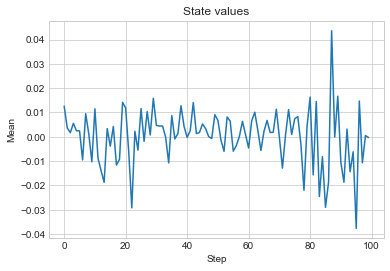

In [24]:
env.render_state_mean_values(n=100)


## 4. Test some random actions and visualize the rewards

### Test some random actions

In [25]:
# test some actions
n=24
rewards = []

print("Actions:")
for _ in range(n):
    action = TradingEnv.ACTIONS[random.randint(0,2)]
    next_state, reward, done = env.step(action)
    rewards.append(reward)
    env.render()


Actions:
hold: vaules rised=False reward=0 done=False
sell: vaules rised=False reward=10 done=False
buy: vaules rised=True reward=20 done=False
buy: vaules rised=False reward=-10 done=False
hold: vaules rised=False reward=0 done=False
sell: vaules rised=False reward=10 done=False
sell: vaules rised=True reward=-10 done=False
hold: vaules rised=False reward=0 done=False
buy: vaules rised=False reward=-10 done=False
hold: vaules rised=True reward=0 done=False
hold: vaules rised=False reward=0 done=False
sell: vaules rised=False reward=10 done=False
hold: vaules rised=False reward=0 done=False
hold: vaules rised=True reward=0 done=False
hold: vaules rised=False reward=0 done=False
buy: vaules rised=True reward=20 done=False
buy: vaules rised=False reward=-10 done=False
sell: vaules rised=True reward=-10 done=False
sell: vaules rised=True reward=-10 done=False
sell: vaules rised=False reward=10 done=False
hold: vaules rised=False reward=0 done=False
sell: vaules rised=False reward=10 done=

### Visualize the rewards


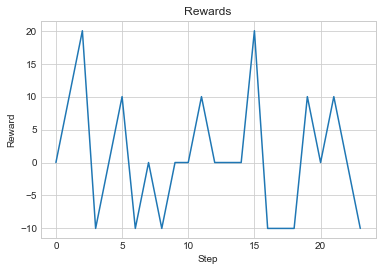

In [26]:
env.plot(range(0,n), rewards, title="Rewards", xlabel="Step", ylabel="Reward")


---
__The end.__

